# Travel Time vs. Headway — Is Travel Time More Predictable?

**Question:** Should we predict inter-station travel time instead of headway?

**Method:** Pull 6 months of southbound A/C/E arrivals, compute both targets, compare with a simple historical-median baseline.

**Verdict:** See final cell.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

LOCAL_PATH = Path("../local_artifacts/corridor_arrivals.parquet")

## 1. Corridor Definition & Data Load

Southbound 8th Ave trunk: 168 St (A09S) → Fulton St (A38S) + WTC (E01S).  
25 stations shared by A, C, and E trains.

In [20]:
# MTA GTFS stop IDs — 8th Ave southbound trunk (A09S–A38S + E01S)
TRUNK_STOPS = {
    "A09S": "168 St",           "A10S": "163 St-Amsterdam Av",
    "A11S": "155 St",           "A12S": "145 St",
    "A14S": "135 St",           "A15S": "125 St",
    "A16S": "116 St",           "A17S": "Cathedral Pkwy (110 St)",
    "A18S": "103 St",           "A19S": "96 St",
    "A20S": "86 St",            "A21S": "81 St-Museum of Natural History",
    "A22S": "72 St",            "A24S": "59 St-Columbus Circle",
    "A25S": "50 St",            "A27S": "42 St-Port Authority",
    "A28S": "34 St-Penn Station", "A30S": "23 St",
    "A31S": "14 St",            "A32S": "W 4 St-Washington Sq",
    "A33S": "Spring St",        "A34S": "Canal St",
    "A36S": "Chambers St",      "A38S": "Fulton St",
    "E01S": "World Trade Center",
}

stop_id_sql = ", ".join(f"'{s}'" for s in sorted(TRUNK_STOPS))
WHERE_CLAUSE = f"""
    direction = 'S'
    AND route_id IN ('A', 'C', 'E')
    AND stop_id IN ({stop_id_sql})
"""
print(f"{len(TRUNK_STOPS)} corridor stops defined")
print(WHERE_CLAUSE)

25 corridor stops defined

    direction = 'S'
    AND route_id IN ('A', 'C', 'E')
    AND stop_id IN ('A09S', 'A10S', 'A11S', 'A12S', 'A14S', 'A15S', 'A16S', 'A17S', 'A18S', 'A19S', 'A20S', 'A21S', 'A22S', 'A24S', 'A25S', 'A27S', 'A28S', 'A30S', 'A31S', 'A32S', 'A33S', 'A34S', 'A36S', 'A38S', 'E01S')



In [21]:
# ── Run ONCE to pull from BigQuery, then use local parquet ──
if not LOCAL_PATH.exists():
    from google.cloud import bigquery
    client = bigquery.Client()
    QUERY = f"""
    SELECT trip_uid, stop_id, track, route_id, direction, arrival_time
    FROM `headway_prediction.clean`
    WHERE {WHERE_CLAUSE}
        AND EXTRACT(DATE FROM arrival_time) BETWEEN '2025-07-18' AND '2026-01-19'
    ORDER BY trip_uid, arrival_time
    """
    df_raw = client.query(QUERY).to_dataframe()
    df_raw.to_parquet(LOCAL_PATH, index=False)
    print(f"Saved {len(df_raw):,} rows")
else:
    df_raw = pd.read_parquet(LOCAL_PATH)
    df_raw['arrival_time'] = pd.to_datetime(df_raw['arrival_time'])

print(f"{len(df_raw):,} rows | {df_raw['trip_uid'].nunique():,} trips | {df_raw['stop_id'].nunique()} stations")
print(f"{df_raw['arrival_time'].min().date()} → {df_raw['arrival_time'].max().date()}")

1,052,112 rows | 76,272 trips | 25 stations
2025-07-18 → 2026-01-19


## 2. Compute Both Targets

In [22]:
# ── Travel time: time between consecutive stops within a trip ──
df = df_raw.sort_values(['trip_uid', 'arrival_time'])
df['next_arrival'] = df.groupby('trip_uid')['arrival_time'].shift(-1)
df['next_stop'] = df.groupby('trip_uid')['stop_id'].shift(-1)
df['travel_time_min'] = (df['next_arrival'] - df['arrival_time']).dt.total_seconds() / 60
df['segment'] = df['stop_id'] + '→' + df['next_stop'].astype(str)

segments = df.dropna(subset=['travel_time_min']).copy()
segments = segments[(segments['travel_time_min'] > 0) & (segments['travel_time_min'] < 30)]

# ── Headway: time between consecutive trains of same route at same station ──
hw = df_raw.sort_values(['stop_id', 'route_id', 'arrival_time']).copy()
hw['prev_arrival'] = hw.groupby(['stop_id', 'route_id'])['arrival_time'].shift(1)
hw['headway_min'] = (hw['arrival_time'] - hw['prev_arrival']).dt.total_seconds() / 60
hw = hw.dropna(subset=['headway_min'])
hw = hw[(hw['headway_min'] > 0.5) & (hw['headway_min'] < 120)]

print(f"Travel time segments: {len(segments):,}")
print(f"Headway observations: {len(hw):,}")

Travel time segments: 975,628
Headway observations: 1,042,558


## 3. Median Baseline — Head-to-Head

In [23]:
TRAIN_END = pd.Timestamp('2025-10-29', tz='UTC')
TEST_END  = pd.Timestamp('2025-12-23', tz='UTC')

def median_baseline(df, target_col, group_cols, fallback_cols):
    """Train/test split → median prediction → MAE."""
    df = df.copy()
    df['hour'] = df['arrival_time'].dt.hour
    df['is_weekend'] = df['arrival_time'].dt.weekday >= 5
    train = df[df['arrival_time'] < TRAIN_END]
    test  = df[(df['arrival_time'] >= TRAIN_END) & (df['arrival_time'] < TEST_END)]

    # Primary: median by (group_cols + hour + is_weekend)
    keys = group_cols + ['hour', 'is_weekend']
    medians = train.groupby(keys)[target_col].median().reset_index(name='pred')
    result = test.merge(medians, on=keys, how='left')

    # Fallback: median by fallback_cols only
    fb = train.groupby(fallback_cols)[target_col].median().to_dict()
    mask = result['pred'].isna()
    result.loc[mask, 'pred'] = result.loc[mask].apply(
        lambda r: fb.get(tuple(r[c] for c in fallback_cols) if len(fallback_cols) > 1 else r[fallback_cols[0]]), axis=1
    )
    result = result.dropna(subset=['pred'])

    mae = (result[target_col] - result['pred']).abs().mean()
    mean_target = result[target_col].mean()
    cv = df[target_col].std() / df[target_col].mean()
    smape = (2 * (result[target_col] - result['pred']).abs() /
             (result[target_col].abs() + result['pred'].abs())).mean() * 100
    return {'n_test': len(result), 'mae_min': mae, 'mae_sec': mae * 60,
            'smape': smape, 'mae_over_mean': mae / mean_target,
            'mean_target': mean_target, 'cv': cv}

tt_results = median_baseline(segments, 'travel_time_min', ['segment'], ['segment'])
hw_results = median_baseline(hw, 'headway_min', ['stop_id', 'route_id'], ['stop_id', 'route_id'])

# ── Results table ──
summary = pd.DataFrame({'Travel Time': tt_results, 'Headway': hw_results}).T
summary['n_test'] = summary['n_test'].astype(int)
print(summary[['n_test', 'mean_target', 'cv', 'mae_min', 'mae_sec', 'smape', 'mae_over_mean']]
      .rename(columns={
          'n_test': 'Test Samples',
          'mean_target': 'Mean (min)',
          'cv': 'CV',
          'mae_min': 'MAE (min)',
          'mae_sec': 'MAE (sec)',
          'smape': 'sMAPE %',
          'mae_over_mean': 'MAE/Mean',
      }).round(3).to_string())

             Test Samples  Mean (min)     CV  MAE (min)  MAE (sec)  sMAPE %  MAE/Mean
Travel Time        289123       2.130  0.658      0.342     20.507   14.536      0.16
Headway            309100      10.088  0.586      3.427    205.610   34.331      0.34


## 4. Visual

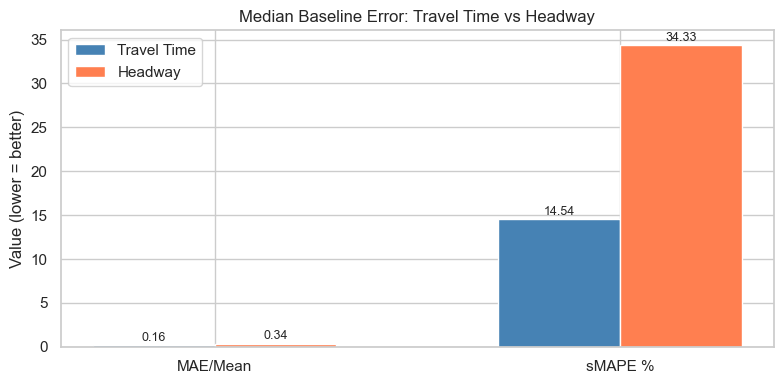

In [24]:
fig, ax = plt.subplots(figsize=(8, 4))
metrics = ['MAE/Mean', 'sMAPE %']
tt_vals = [tt_results['mae_over_mean'], tt_results['smape']]
hw_vals = [hw_results['mae_over_mean'], hw_results['smape']]

x = np.arange(len(metrics))
w = 0.3
ax.bar(x - w/2, tt_vals, w, label='Travel Time', color='steelblue')
ax.bar(x + w/2, hw_vals, w, label='Headway', color='coral')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel('Value (lower = better)')
ax.set_title('Median Baseline Error: Travel Time vs Headway')
ax.legend()

for i, (tv, hv) in enumerate(zip(tt_vals, hw_vals)):
    ax.text(i - w/2, tv + 0.5, f'{tv:.2f}', ha='center', fontsize=9)
    ax.text(i + w/2, hv + 0.5, f'{hv:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

## Verdict

| Metric | Travel Time | Headway |
|--------|------------|----------|
| MAE | **20.5 sec** | 205.6 sec |
| MAE / Mean | **0.160** | 0.340 |
| sMAPE | **14.5%** | 34.3% |

Travel time baseline error is **half** the relative error of headway.  
A dumb median already gets within 20 seconds — there's a tight, regular signal to model.  
Headway is 2x noisier relative to its mean.

**Recommendation:** Reframe the prediction target from headway to inter-station travel time.